In [28]:
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import math
import ast
from scipy.stats import median_abs_deviation, hypergeom, mannwhitneyu
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
# Saving plots with editable text
plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts (editable text)

In [17]:
import dictys
from utils_custom import *
from pseudotime_curves import *
from episode_plots import *
from episodic_dynamics import *

In [3]:
# Define file paths 
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures'
input_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'

# Cell state distributions per fate

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

#### Get cell state labels for each window

In [5]:
cell_labels_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/data/clusters.csv'
cell_labels = pd.read_csv(cell_labels_file, header=0)
display(cell_labels.head())
display(cell_labels.index)

,Barcode,Cluster
0,AAACAGCCAAGCCACT-3,GC-1
1,AAACAGCCAAGGTGCA-1,ActB-2
2,AAACAGCCAAGTTATC-1,ActB-1
3,AAACAGCCAATAGCCC-1,ActB-1
4,AAACAGCCAGTTAGCC-1,ActB-1


RangeIndex(start=0, stop=28494, step=1)

In [8]:
cell_assignment_matrix = dictys_dynamic_object.prop["sc"]["w"]
state_labels_in_window = {}
for window_idx in range(cell_assignment_matrix.shape[0]):
    indices_of_cells_present_in_window = np.where(
        cell_assignment_matrix[window_idx] == 1
        )[0] #these indices start from 0
    state_labels_in_window[window_idx] = [
        cell_labels.iloc[int(idx)]['Cluster'] for idx in indices_of_cells_present_in_window
        ]

In [ ]:
state_count_per_window = window_labels_to_count_df(state_labels_in_window)
state_count_per_window = state_count_per_window.drop(index=['ActB-1', 'earlyActB'])
display(state_count_per_window)

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
ActB-2,128,6,0,0,86,78,55,38,34,29,...,0,0,0,0,0,0,0,0,0,0
ActB-3,588,0,0,0,701,753,809,869,892,918,...,0,0,0,0,0,0,0,0,0,0
ActB-4,264,0,0,0,200,157,124,82,66,49,...,0,0,0,0,0,0,0,0,0,0
GC-1,1,0,0,224,0,0,0,0,0,0,...,531,515,468,442,420,375,350,321,294,288
GC-2,10,0,0,776,8,8,8,8,6,3,...,468,484,531,558,580,625,650,679,706,712
PB-2,2,0,995,0,1,1,1,0,0,0,...,1,1,1,0,0,0,0,0,0,0
earlyPB,6,0,5,0,3,2,2,2,2,1,...,0,0,0,0,0,0,0,0,0,0


#### Plot the label distribution across windows

In [10]:
PB_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2]
GC_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3]
PB_post_bifurcation_window_indices = [0] + list(range(98, 147, 1)) + [2]
GC_post_bifurcation_window_indices = [0] + list(range(147, 193, 1)) + [3]

In [14]:
# Define distinct colors for better visibility
colors_cell_count = {
    'ActB-1': '#87CEFA',     # lightskyblue
    'ActB-2': '#1E90FF',     # dodgerblue
    'ActB-3': '#00008B',     # darkblue
    'ActB-4': '#9370DB',     # mediumorchid
    'GC-1': '#7BDE7B',       # custom light green
    'GC-2': '#008000',       # green
    'PB-2': '#BB3636',       # custom red
    'earlyActB': '#008080',   # teal
    'earlyPB': '#F08080'   # lightcoral
}

In [18]:
time_scale_object = AlignTimeScales(dictys_dynamic_object, trajectory_range=[0, 2])
pseudotime_values_of_windows = time_scale_object.pseudotime_of_windows()

Time points per bin: [1, 2, 3, 2, 1, 2, 6, 31]
Total cells per bin: [np.float64(999.0), np.float64(993.0), np.float64(989.6666666666666), np.float64(989.0), np.float64(994.0), np.float64(996.0), np.float64(999.5), np.float64(1000.0000000000001)]


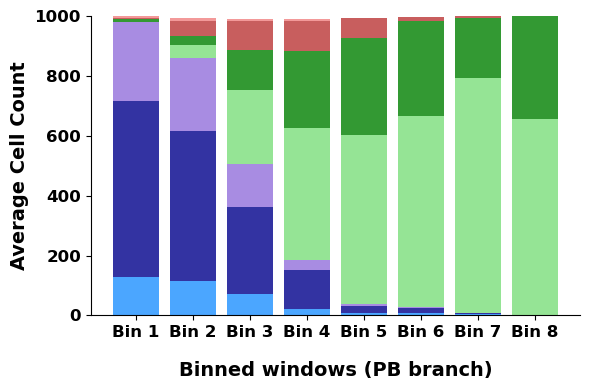

In [33]:
# Create a new dataframe with only the columns in PB_fate_window_indices
df_plot = state_count_per_window[GC_post_bifurcation_window_indices]
# Create time bins
n_bins = 8  # Adjust this number as needed
x = [pseudotime_values_of_windows[i] for i in GC_post_bifurcation_window_indices]
x_min, x_max = min(x), max(x)

# Create bin edges
bin_edges = np.linspace(x_min, x_max, n_bins + 1)
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(n_bins)]

# Initialize binned data and count time points per bin
binned_data = {state: [0] * n_bins for state in df_plot.index}
bin_counts = [0] * n_bins  # Track how many time points are in each bin

# Aggregate data into bins
for i, time_point in enumerate(x):
    # Find which bin this time point belongs to
    bin_idx = np.digitize(time_point, bin_edges) - 1
    bin_idx = max(0, min(bin_idx, n_bins - 1))  # Ensure within bounds
    
    # Add counts for each cell state to the appropriate bin
    for state in df_plot.index:
        binned_data[state][bin_idx] += df_plot.loc[state].values[i]
    
    bin_counts[bin_idx] += 1

# Average the counts within each bin (so each bin represents average composition)
for state in df_plot.index:
    for bin_idx in range(n_bins):
        if bin_counts[bin_idx] > 0:
            binned_data[state][bin_idx] = binned_data[state][bin_idx] / bin_counts[bin_idx]

# Plot
plt.figure(figsize=(6, 4))
plt.style.use('default')
plt.grid(False)

# Initialize bottom array for stacking
bottom = [0] * n_bins

# Plot each cell state as a layer in the stacked bar
for state in df_plot.index:
    y = binned_data[state]
    plt.bar(range(n_bins), y,
            label=state,
            color=colors_cell_count[state],
            bottom=bottom,
            alpha=0.8)
    
    # Update bottom for next stack layer
    bottom = [bottom[i] + y[i] for i in range(n_bins)]

plt.xlabel('Binned windows (PB branch)', fontsize=14, fontweight='bold', labelpad=15)
plt.ylabel('Average Cell Count', fontsize=14, fontweight='bold')
plt.xticks(range(n_bins), [f"Bin {i+1}" for i in range(n_bins)], fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# save figure
plt.savefig(os.path.join(output_folder, 'fig4_state_count_GC_bins.pdf'), dpi=1200)
#plt.show()
# Print bin info for verification
print("Time points per bin:", bin_counts)
print("Total cells per bin:", [sum(binned_data[state][i] for state in df_plot.index) for i in range(n_bins)])

# Episodic enrichment plots
### Direct effect enrichment 

In [ ]:
### State discriminative LFs 
# PB
pb_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep1_pb.csv"
pb_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep2_pb.csv"
pb_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep3_pb.csv"
pb_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep4_pb.csv"
# GC
gc_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep1_gc.csv"
gc_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep2_gc.csv"
gc_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep3_gc.csv"
gc_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep4_gc.csv"


In [ ]:
### TF perturbation LFs
# irf4 model 
# GC
gc_irf4_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_1.csv"
gc_irf4_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_2.csv"
gc_irf4_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_3.csv"
gc_irf4_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_4.csv"
gc_irf4_ep5 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_5.csv"
gc_irf4_ep6 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_6.csv"
gc_irf4_ep7 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_7.csv"
gc_irf4_ep8 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/gc_98/enrichment_episode_8.csv"

# prdm1 model 
# GC
gc_blimp1_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_1.csv"
gc_blimp1_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_2.csv"
gc_blimp1_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_3.csv"
gc_blimp1_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_4.csv"
gc_blimp1_ep5 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_5.csv"
gc_blimp1_ep6 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_6.csv"
gc_blimp1_ep7 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_7.csv"
gc_blimp1_ep8 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/prdm1_ko/gc_98/enrichment_episode_8.csv"


In [ ]:
# ets1 sig LFs
ets1_sig_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/sig_LFs/enrichment_episode_1.csv"
ets1_sig_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/sig_LFs/enrichment_episode_2.csv"
ets1_sig_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/sig_LFs/enrichment_episode_3.csv"
ets1_sig_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/sig_LFs/enrichment_episode_4.csv"
ets1_sig_ep5 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/sig_LFs/enrichment_episode_5.csv"
ets1_sig_ep6 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/sig_LFs/enrichment_episode_6.csv"

# ets1 all LFs
ets1_all_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/all_lfs/enrichment_episode_1.csv"
ets1_all_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/all_lfs/enrichment_episode_2.csv"
ets1_all_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/all_lfs/enrichment_episode_3.csv"
ets1_all_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/all_lfs/enrichment_episode_4.csv"
ets1_all_ep5 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/all_lfs/enrichment_episode_5.csv"
ets1_all_ep6 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ets1/all_lfs/enrichment_episode_6.csv"


In [ ]:
# ikzf1 sig LF model 
ikzf1_sig_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/sig_lfs/enrichment_episode_1.csv"
ikzf1_sig_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/sig_lfs/enrichment_episode_2.csv"
ikzf1_sig_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/sig_lfs/enrichment_episode_3.csv"
ikzf1_sig_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/sig_lfs/enrichment_episode_4.csv"
ikzf1_sig_ep5 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/sig_lfs/enrichment_episode_5.csv"
ikzf1_sig_ep6 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/sig_lfs/enrichment_episode_6.csv"

# ikzf1 all LF model 
ikzf1_all_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/all_lfs/enrichment_episode_1.csv"
ikzf1_all_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/all_lfs/enrichment_episode_2.csv"
ikzf1_all_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/all_lfs/enrichment_episode_3.csv"
ikzf1_all_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/all_lfs/enrichment_episode_4.csv"
ikzf1_all_ep5 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/all_lfs/enrichment_episode_5.csv"
ikzf1_all_ep6 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ntc/output/ikzf1/all_lfs/enrichment_episode_6.csv"


In [ ]:
def plot_tf_episodic_enrichment_dotplot(
    dfs,
    episode_labels,
    figsize=(12, 8),
    min_dot_size=10,
    max_dot_size=300,
    p_value_threshold=0.05,
    min_significance_threshold=None,
    min_targets_in_lf=2,
    min_targets_dwnstrm=2,
    cmap_name="coolwarm",
    value_legend_title="ES",
    size_legend_title="P-val",
    sort_by_gene_similarity=False,
    show_dendrogram=False,
    dendrogram_ratio=0.2,
    figure_title=None,
    log_scale=False,
    show_plot=True,
    tf_order=None
):
    """
    Plots a dotplot for TF episodic enrichment where dot color represents enrichment score 
    and dot size represents p-value significance (smaller p-value = larger dot).
    
    TFs can be sorted in three ways (priority order):
    1. Custom order (if tf_order is provided)
    2. Gene similarity clustering (if sort_by_gene_similarity=True)
    3. Alphabetical (default)
    
    Parameters:
    -----------
    tf_order : list of str, optional
        Custom order for TF rows. If provided, overrides other sorting methods.
        TFs not in the list will be appended alphabetically at the end.
        TFs in the list but not in the data will be ignored.
    """    
    # 1. Input validation
    required_cols = ['TF', 'p_value', 'enrichment_score', 'genes_in_lf', 'genes_dwnstrm']
    
    for i, df in enumerate(dfs):
        if df is None or df.empty:
            print(f"Episode {i+1} dataframe is None or empty.")
            return None, None, None  # FIXED: Changed from return None, None
        for col in required_cols:
            if col not in df.columns:
                print(f"Episode {i+1} dataframe missing required column: {col}")
                return None, None, None  # FIXED: Changed from return None, None
    
    # 2. Helper function to parse genes_in_lf column
    def parse_genes_in_lf(genes_str):
        """Parse the string representation of genes tuple."""
        try:
            if pd.isna(genes_str) or genes_str == '' or genes_str == '()':
                return set()
            # Handle string representation of tuples
            genes_tuple = ast.literal_eval(genes_str)
            if isinstance(genes_tuple, tuple):
                return set(genes_tuple)
            elif isinstance(genes_tuple, str):
                return {genes_tuple}
            else:
                return set()
        except:
            return set()
                
    # 3. Collect all TFs and their associated genes across all episodes
    tf_genes_dict = {}  # TF -> set of genes across all episodes
    tf_dwnstrm_genes_dict = {}  # TF -> set of downstream genes across all episodes
    plot_data_list = []
    
    for i, (df, episode_label) in enumerate(zip(dfs, episode_labels)):
        df_clean = df.dropna(subset=['TF', 'p_value', 'enrichment_score'])
        
        for _, row in df_clean.iterrows():
            tf_name = row['TF']
            genes_in_lf_set = parse_genes_in_lf(row.get('genes_in_lf', ''))
            genes_dwnstrm_set = parse_genes_in_lf(row.get('genes_dwnstrm', ''))
            
            # Accumulate genes for each TF across episodes
            if tf_name not in tf_genes_dict:
                tf_genes_dict[tf_name] = set()
                tf_dwnstrm_genes_dict[tf_name] = set()
            tf_genes_dict[tf_name].update(genes_in_lf_set)
            tf_dwnstrm_genes_dict[tf_name].update(genes_dwnstrm_set)
            
            plot_data_list.append({
                'episode': episode_label,
                'episode_idx': i,
                'TF': tf_name,
                'p_value': row['p_value'],
                'enrichment_score': row['enrichment_score']
            })
    
    if not plot_data_list:
        print("No valid data found across all episodes.")
        return None, None, None  # FIXED, None  # FIXED: Changed from return None, None
    
    plot_data_df = pd.DataFrame(plot_data_list)
    
    # 4. Filter TFs based on gene count criteria (AND condition)
    valid_tfs = set()
    for tf_name in tf_genes_dict.keys():
        lf_gene_count = len(tf_genes_dict[tf_name])
        dwnstrm_gene_count = len(tf_dwnstrm_genes_dict[tf_name])
        
        if lf_gene_count >= min_targets_in_lf and dwnstrm_gene_count >= min_targets_dwnstrm:
            valid_tfs.add(tf_name)
    
    if not valid_tfs:
        print(f"No TFs meet the criteria: >= {min_targets_in_lf} LF genes AND >= {min_targets_dwnstrm} downstream genes")
        return None, None, None  # FIXED, None  # FIXED: Changed from return None, None
    
    # Filter plot data and gene dictionaries to only include valid TFs
    plot_data_df = plot_data_df[plot_data_df['TF'].isin(valid_tfs)]
    tf_genes_dict = {tf: genes for tf, genes in tf_genes_dict.items() if tf in valid_tfs}
    tf_dwnstrm_genes_dict = {tf: genes for tf, genes in tf_dwnstrm_genes_dict.items() if tf in valid_tfs}
    
    print(f"Filtered to {len(valid_tfs)} TFs that meet gene count criteria")
    
    # 5. Filter TFs based on significance threshold
    if min_significance_threshold is not None:
        # Find TFs that have at least one episode with p-value < min_significance_threshold
        significant_tfs = set()
        tf_min_pvalues = plot_data_df.groupby('TF')['p_value'].min()
        significant_tfs = set(tf_min_pvalues[tf_min_pvalues < min_significance_threshold].index)
        
        if not significant_tfs:
            print(f"No TFs meet the minimum significance threshold of {min_significance_threshold}")
            return None, None, None  # FIXED, None  # FIXED: Changed from return None, None

        # Filter the plot data to only include significant TFs
        plot_data_df = plot_data_df[plot_data_df['TF'].isin(significant_tfs)]
        
        # Update tf_genes_dict to only include significant TFs
        tf_genes_dict = {tf: genes for tf, genes in tf_genes_dict.items() if tf in significant_tfs}
        
        print(f"Further filtered to {len(significant_tfs)} TFs that meet significance threshold < {min_significance_threshold}")

    # 6. Sort TFs based on specified method
    # Priority: custom order > gene similarity > alphabetical
    if tf_order is not None:
        # Use custom order
        available_tfs = set(tf_genes_dict.keys())
        
        # Filter custom order to only include TFs present in the data
        all_tfs_sorted = [tf for tf in tf_order if tf in available_tfs]
        
        # Add any TFs not in custom order (alphabetically sorted)
        remaining_tfs = sorted(available_tfs - set(all_tfs_sorted))
        all_tfs_sorted.extend(remaining_tfs)
        
        linkage_matrix = None
        original_tf_labels = None
        
        if remaining_tfs:
            print(f"Note: {len(remaining_tfs)} TFs not in custom order were added alphabetically: {remaining_tfs}")
            
    elif sort_by_gene_similarity:
        if show_dendrogram:
            all_tfs_sorted, linkage_matrix, original_tf_labels = sort_tfs_by_gene_similarity(
                tf_genes_dict, return_linkage=True)
        else:
            all_tfs_sorted = sort_tfs_by_gene_similarity(tf_genes_dict)
            linkage_matrix = None
            original_tf_labels = None
    else:
        all_tfs_sorted = sorted(tf_genes_dict.keys())
        linkage_matrix = None
        original_tf_labels = None
    
    # 7. Map p-values to dot sizes (updated using Scanpy-like logic)
    def p_value_to_size(p_val):
        if p_val > p_value_threshold:
            return min_dot_size * 0.5  # Smaller dot for non-significant
        # Scale significant p-values
        min_p_cap = 1e-6  # Prevents -log10(0)
        log_p = -np.log10(max(p_val, min_p_cap))
        log_thresh = -np.log10(p_value_threshold)
        log_min_cap = -np.log10(min_p_cap)
        
        if log_min_cap == log_thresh:
            scaled_val = 1.0  # Avoid div-by-zero
        else:
            scaled_val = (log_p - log_thresh) / (log_min_cap - log_thresh)
        
        size = min_dot_size + (max_dot_size - min_dot_size) * min(scaled_val, 1.0)
        return size

    plot_data_df['dot_size'] = plot_data_df['p_value'].apply(p_value_to_size)

    # apply log scale to enrichment score
    if log_scale:
        # add offset
        min_enrichment = plot_data_df['enrichment_score'].min()
        if min_enrichment <= 0:
            offset = abs(min_enrichment) + 1e-6
            plot_data_df['enrichment_score_log'] = np.log2(plot_data_df['enrichment_score'] + offset)
            value_legend_title = f"log2({value_legend_title} + {offset:.1e})"
        else:
            plot_data_df['enrichment_score_log'] = np.log2(plot_data_df['enrichment_score'])
            value_legend_title = f"log2({value_legend_title})"
        
        # Use log-transformed values for coloring
        color_values = plot_data_df['enrichment_score_log']
    else:
        color_values = plot_data_df['enrichment_score']

    # 8. Create coordinate mappings
    episode_x_coords = {label: i for i, label in enumerate(episode_labels)}
    tf_y_coords = {tf: i for i, tf in enumerate(all_tfs_sorted)}
    
    # 9. Create figure with subplots
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        # Create figure with dendrogram and main plot
        fig = plt.figure(figsize=figsize)
        
        # Calculate subplot widths
        dendro_width = dendrogram_ratio
        main_width = 1 - dendrogram_ratio - 0.15  # Leave space for colorbar
        
        # Create subplots
        ax_dendro = fig.add_subplot(1, 2, 1)
        ax_main = fig.add_subplot(1, 2, 2)
        
        # Adjust subplot positions
        dendro_left = 0.05
        main_left = dendro_left + dendro_width + 0.02
        
        ax_dendro.set_position([dendro_left, 0.1, dendro_width, 0.8])
        ax_main.set_position([main_left, 0.1, main_width, 0.8])

        # Plot dendrogram
        dendro_plot = dendrogram(
            linkage_matrix, 
            ax=ax_dendro,
            orientation='left',
            labels=original_tf_labels,
            leaf_font_size=8,
            color_threshold=0.7*max(linkage_matrix[:,2])
        )
        ax_dendro.invert_yaxis()
        ax_dendro.set_ylabel("TF Clustering")
        ax_dendro.set_xlabel("Distance")
        ax_dendro.spines['top'].set_visible(False)
        ax_dendro.spines['right'].set_visible(False)
        
        # Remove x-axis labels for cleaner look
        ax_dendro.tick_params(axis='y', which='both', left=False, labelleft=False)
        
    else:
        # Standard single plot
        fig, ax_main = plt.subplots(figsize=figsize)
    
    # 10. Create scatter plot
    scatter = ax_main.scatter(
        x=plot_data_df['episode'].map(episode_x_coords),
        y=plot_data_df['TF'].map(tf_y_coords),
        s=plot_data_df['dot_size'],
        c=color_values,
        cmap=cmap_name,
        edgecolors='gray',
        linewidths=0.5,
        alpha=0.8
    )
    
    # 11. Axis formatting
    # X-axis (Episodes)
    ax_main.set_xticks(list(episode_x_coords.values()))
    ax_main.set_xticklabels(episode_labels, rotation=0, ha="center")
    # Add horizontal padding to main plot
    x_pad = 0.5  # tweak this to get desired spacing
    ax_main.set_xlim(-x_pad, len(episode_labels) - 1 + x_pad)

    ax_main.set_xlabel("Episodes", fontsize=12, fontweight='bold', labelpad=15)
    
    # Y-axis (TFs)
    ax_main.set_yticks(list(tf_y_coords.values()))
    ax_main.set_yticklabels(all_tfs_sorted)
    ax_main.set_ylabel("TFs", fontsize=12, fontweight='bold')
    # 12. Size legend for P-values
    # Create representative p-values for the legend
    legend_p_values = [0.001, 0.01]
    legend_dots = []
    
    for p_val in legend_p_values:
        size_val = p_value_to_size(p_val)
        if p_val > p_value_threshold:
            label_text = f"{p_value_threshold}"
        else:
            label_text = f"{p_val}"
        legend_dots.append(plt.scatter([], [], s=size_val, c='gray', label=label_text))
    
    # Position the size legend
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        bbox_anchor = (1.25, 0.6)
    else:
        bbox_anchor = (1.18, 0.6)
        
    size_leg = ax_main.legend(
        handles=legend_dots, 
        title=size_legend_title,
        bbox_to_anchor=bbox_anchor, 
        loc='center left',
        labelspacing=1.5, 
        borderpad=1, 
        frameon=True,
        handletextpad=1.5,
        scatterpoints=1
    )
    
    # 13. Horizontal Colorbar for Enrichment Score (positioned below p-value legend)
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        # Create axes for horizontal colorbar below the p-value legend
        cbar_ax = fig.add_axes([0.85, 0.15, 0.3, 0.03])  # [left, bottom, width, height]
    else:
        # Create axes for horizontal colorbar below the p-value legend
        cbar_ax = fig.add_axes([0.65, 0.4, 0.2, 0.02])  # [left, bottom, width, height]
    
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(value_legend_title, fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # 14. Final formatting
    sorting_method = "gene similarity" if sort_by_gene_similarity else "alphabetical" 
    ax_main.grid(True, linestyle='--', alpha=0.3, axis='both')
    ax_main.tick_params(axis='both', which='major', pad=5)
    
    # Invert y-axis so first TF is at top
    ax_main.invert_yaxis()
    
    # Add figure title if provided
    if figure_title is not None:
        fig.suptitle(figure_title, fontsize=14, fontweight='bold', y=0.95)

    if show_plot:
        plt.tight_layout()
        plt.show()
    
    return fig, plot_data_df, all_tfs_sorted

In [ ]:
df_ep1 = pd.read_csv(gc_ep1)
df_ep2 = pd.read_csv(gc_ep2)
df_ep3 = pd.read_csv(gc_ep3)
df_ep4 = pd.read_csv(gc_ep4)

In [ ]:
# Define your desired TF order
# custom_tf_order_prdm1 = ['BPTF', 'SP1', 'BATF3', 'RBPJ', 'IKZF2']
# custom_tf_order_irf4 = ['MBD2', 'IKZF2', 'RBPJ', 'TCF12', 'BACH1', 'HMG20A']
# custom_tf_order_ets1_sig = ['Hdac2', 'Nfkb1', 'Ets1', 'Sin3a', 'Max']
# custom_tf_order_ikzf1_all = ['Ep300', 'E2f2', 'Klf6', 'Nfe2', 'Taf1', 'Nr4a2', 'Bhlhe40', 'Rad21', 'Klf2', 'Ctcf']
# custom_tf_order_ets1_all = ['Myc', 'Nfe2', 'Ets1', 'Elf1', 'Srf', 'Max', 'E2f2', 'Bhlhe41', 'Sp4']
# custom_tf_order_z11_pb = ['CREB3L2', 'MEF2C', 'TFEC', 'TEAD2', 'IRF8', 'IRF9']
custom_tf_order_z11_gc = ['IKZF3', 'USF2', 'IRF7', 'MEF2C', 'CDC5L', 'POU2F1']

# Use it in the plot
fig, plot_data, plotted_tfs = plot_tf_episodic_enrichment_dotplot(
    dfs=[df_ep1, df_ep2, df_ep3, df_ep4],
    episode_labels=['ActB3/4', '.', '..', 'lateGC'],
    figsize=(4.5, 4), #breadth by length
    p_value_threshold=0.009,
    min_significance_threshold=0.009, 
    min_targets_in_lf=2,
    min_targets_dwnstrm=2,
    cmap_name="Greens",
    tf_order=custom_tf_order_z11_gc,
    figure_title=None,
    log_scale=True
)
# save the plot
fig.savefig(os.path.join(output_folder, "z11_ee_gc.pdf"), dpi=300)
#0.0015 for PB, 0.009 for GC in the gc_pb lf
#0.0015 for prdm1 ko, 0.012 for irf4 ko

# Chromatin level TF activity over pseudotime